In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from catheter import FNO1d, FNO1d_updated
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def Lx2length(L_x, L_p, x1, x2, x3, h):
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x2:
        l = l0 + l1*(L_x + x3)/(x3-x2)
    elif L_x < -x1:
        l = l0 + l1 + l2*(L_x + x2)/(x2-x1)
    else:
        l = l0 + l1 + l2 + L_x+x1

    return l

def d2xy(d, L_p, x1, x2, x3, h):
    
    p0, p1, p2, p3 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x2, h]), torch.tensor([x1,0.0])
    v0, v1, v2, v3 = torch.tensor([x3-0,0.0]), torch.tensor([x2-x3,h]), torch.tensor([x1-x2,-h]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3 = -x3, torch.sqrt((x2-x3)**2 + h**2), torch.sqrt((x1-x2)**2 + h**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = (d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    

    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = ((x1 + L_p) + (0 - x3) + torch.sqrt((x2 - x1)**2 + h**2) + torch.sqrt((x3 - x2)**2 + h**2))
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, h)
        
    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




1d X error =  0.0005472336590786564
1d Y error =  0.00038736877123649244


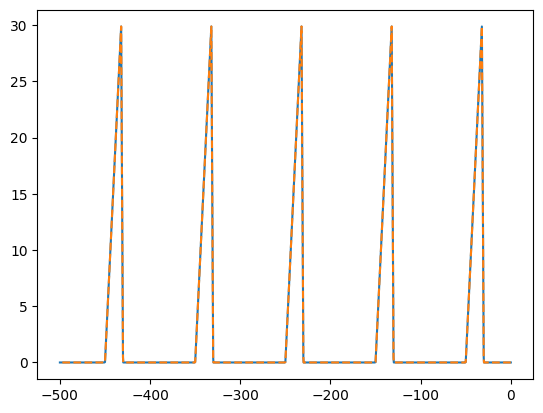

In [3]:
L_x, L_p, x2, x3, h = 500, 100, -32, -30, 30
x1 = -0.5*L_p
N_s = 1001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)

L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)



print("1d X error = ", np.linalg.norm(X0 - X.cpu().numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.cpu().numpy()))
X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X0, Y0)
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


(2001, 300) (7, 300) (2001, 300)
(2001, 100) (2001, 100) (2001, 100)
torch.Size([1, 2001, 3])
[ 22.           5.03923     60.09925132 -30.04962566 -11.64557141
 -15.02815168  29.89950206]
sample =  22.0
min loss =  209298.5229611952 L_p, x2, x3, h =  tensor(60.0993) tensor(-11.6456) tensor(-15.0282) tensor(29.8995)
predicted loss:  294731.001262608
predicted loss updated:  240129.38383512272
-85432.47830141264
-30830.860873927402
0.24987506246876562


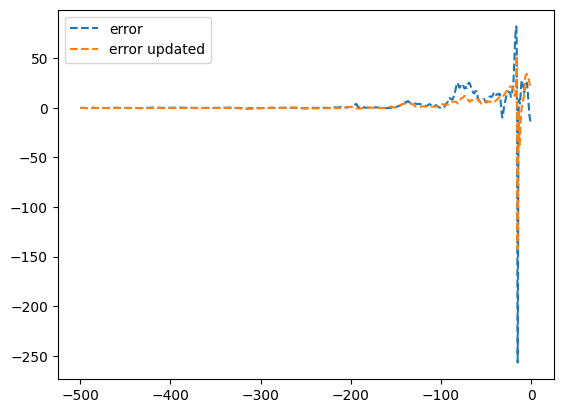

In [4]:
# All data design results
PATH = "/home/wumming/Documents/GNN-PDE/Geo-FNO-catheter/data/test/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
print(np.load(INPUT_X).shape, np.load(INPUT_para).shape, np.load(OUTPUT).shape)
inputX_raw = np.load(INPUT_X)[:, 0:n_data]
inputY_raw = np.load(INPUT_Y)[:, 0:n_data]
inputPara_raw = np.load(INPUT_para)[:, 0:n_data]
output_raw = np.load(OUTPUT)[:, 0:n_data]


# nx ny
L_x , N_s = 500.0, 2001

################################################################
# load data and data normalization
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0
print(inputX.shape, inputY.shape, output.shape)


n_data = inputX.shape[1]
all_loss = np.zeros(n_data)


for i in range(n_data):
    
    sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    all_loss[i] = -np.dot(output[:, i], xx_mask) * L_x/N_s

    

loss_min_ind = np.argmin(all_loss)
loss_min = all_loss[loss_min_ind]
sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]

model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
model2 = torch.load("FNO1d_updated_m12w128e400_noise_mask", map_location=device)
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
print(model2(X_Y).shape)
out2 = torch.exp(model2(X_Y)).mean(-1).squeeze().detach().cpu().numpy()


print(inputPara[:, loss_min_ind])
print("sample = ", sample)
print("min loss = ", loss_min, "L_p, x2, x3, h = ", L_p, x2, x3, h)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
print("predicted loss: ", -np.dot(out, xx_mask) * L_x/N_s)
print("predicted loss updated: ", -np.dot(out2, xx_mask) * L_x/N_s)

density = output[:, loss_min_ind]
mesh_X = inputX[:, loss_min_ind]
mesh_Y = inputY[:, loss_min_ind]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="error")
plt.plot(xx_mask, out2 - density, "--", label="error updated")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(np.dot(out2 - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

-27188.28157945494
-7083.468633391425
0.24987506246876562


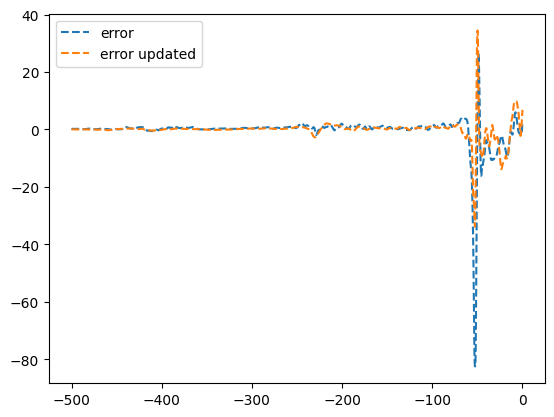

In [5]:
index = 0

sample, uf, L_p, x1, x2, x3, h = inputPara[:, index]
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)

out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
out2 = torch.exp(model2(X_Y)).mean(-1).squeeze().detach().cpu().numpy()

density = output[:, index]
mesh_X = inputX[:, index]
mesh_Y = inputY[:, index]
plt.figure()
# plt.plot(xx_mask, density, label="Reference")
plt.plot(xx_mask, out - density, "--", label="error")
plt.plot(xx_mask, out2 - density, "--", label="error updated")
# plt.plot(mesh_X, mesh_Y)
plt.legend()

print(np.dot(out - density, xx_mask) * L_x/N_s)
print(np.dot(out2 - density, xx_mask) * L_x/N_s)
print(L_x/N_s)

In [6]:
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/2 - 15)/(1 + torch.exp(theta[2]))
    x2 = -L_p  + L_p/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, h


def inv_transfer(L_p, x2, x3, h):
    x1 = -0.5*L_p
    theta = np.zeros(4)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( L_p/(x2 + L_p) - 1 )
    theta[2] = np.log( (L_p/2 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta

In [17]:
################################################################
# inverse optimization with genetic optimization
################################################################
seed = 2
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

model = torch.load("FNO1d_updated_m12w128e400_noise_mask", map_location=device)
print(count_params(model))


N_iter = 50
N_par = 16

# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/2
#             -L_p < x2      < 0
#               20 < h       < 30
# def transfer(theta):


# sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
L_p, x2, x3, h = 100.0, -40.0, -30.0, 25.0
# L_p, x2, x3, h = 61.0, -30.0, -12.5, 29.0
# x2, x3, h = 73.85438537597656, -9.479606628417969, -19.35201644897461, 27.60188102722168
theta0 =  inv_transfer(L_p, x2, x3, h) 
print("initialize : ", theta0)

theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)

theta = theta.reshape(1, 4).repeat(N_par, 1)
print("initialize : ", transfer(theta))

bacteria_pred = []
L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).reshape(1,N_s).to(device)

loss_min = torch.tensor(np.inf)

loss_all = torch.zeros(N_iter, N_par)
loss_all_min = []
theta_min = 0


# theta (N_par, 4)
for t in range(N_iter):
    torch.cuda.empty_cache()
    t1 = default_timer()
    
    # mutate
    noise = torch.randn(theta.shape)
    theta = theta + noise

    # evaluate
    for i in range(N_par):
        L_p, x1, x2, x3, h = transfer(theta[i])  
        x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        x = x.cuda()
        out = torch.exp(model(x)).mean(-1).squeeze()
        loss_all[t, i] = (-torch.sum(out*xx_mask)* L_x/N_s).item()
        
        del x, out
        
        if loss_all[t, i] < loss_min:
            theta_min = theta[i]
            loss_min = loss_all[t, i]
        
    # record
    loss_t = loss_all[t]
    loss_t_min = torch.min(loss_t)
    loss_all_min.append(loss_t_min)

    
    # select the parents
    index = torch.topk(loss_t, k=N_par//4, dim=0).indices
    temp = theta[index] #(N//4, 4)
    
    # breed
    fathers = temp.repeat(4,1) #(N, 4)
    mothers = fathers[torch.randperm(N_par)] #(N, 4)
    average = (fathers + mothers)/2
    temp = torch.stack([fathers, mothers, average], dim=-1) #(N, 4, 3)
    
    rand_index= torch.randint(3, (N_par, 4)) # 0-> from father; 1-> from mother; 2-> average
    N_index = torch.arange(N_par).reshape(N_par, 1).repeat(1, 4) #(N, 4)
    theta_index = torch.arange(4).reshape(1, 4).repeat(N_par, 1) #(N, 4)
#     index = torch.stack([rand_index, N_index, theta_index], dim=-1) #(N, 4, 3)
    child = temp[N_index, theta_index, rand_index] #(N, 4)
    
    t2 = default_timer()
    print(t, N_par, t2 - t1,  "loss = ", loss_t_min.item(), "loss_min = ", loss_min.item(),)

1018883
initialize :  [ 1.32175584 -0.40546511  1.79175947  0.        ]
initialize :  (tensor([100.0000, 174.0000,  87.1429, 155.0000], grad_fn=<AddBackward0>), tensor([-50.0000, -87.0000, -43.5714, -77.5000], grad_fn=<MulBackward0>), tensor([-78.9474, -69.6000, -74.6939, -77.5000], grad_fn=<AddBackward0>), tensor([-27.6316, -28.8000, -24.4898, -31.2500], grad_fn=<AddBackward0>), tensor([22.1053, 26.0000, 21.4286, 25.0000], grad_fn=<AddBackward0>))
0 16 0.049428071004513185 loss =  375376.375 loss_min =  375376.375
1 16 0.046411180002905894 loss =  720271.0 loss_min =  375376.375
2 16 0.0463996690014028 loss =  402036.25 loss_min =  375376.375
3 16 0.04624684900045395 loss =  387639.375 loss_min =  375376.375
4 16 0.04819578900060151 loss =  458054.25 loss_min =  375376.375
5 16 0.0464659510034835 loss =  401838.09375 loss_min =  375376.375
6 16 0.046225957994465716 loss =  408712.75 loss_min =  375376.375
7 16 0.046234297995397355 loss =  426066.0625 loss_min =  375376.375
8 16 0.0462

# plot


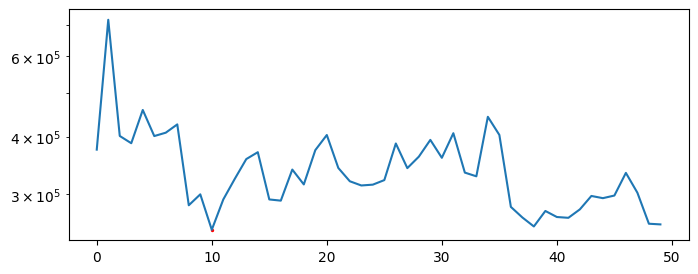

In [18]:
loss_all = loss_all_min

fig = plt.figure(figsize=(8,3))
plt.semilogy(loss_all, "-", markersize=1)
minind = np.array(loss_all).argmin()
plt.scatter(minind, loss_all[minind], color="red", s=2)
fig.savefig("optimization-loss.pdf")


1570

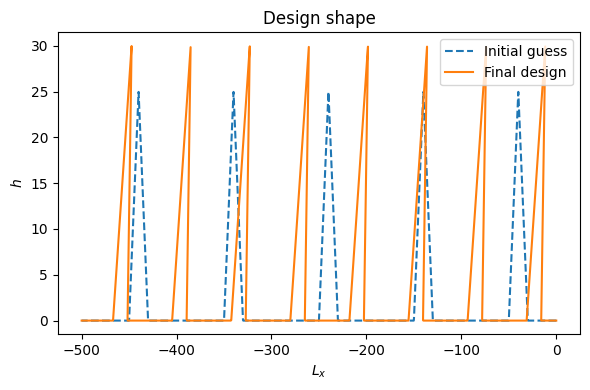

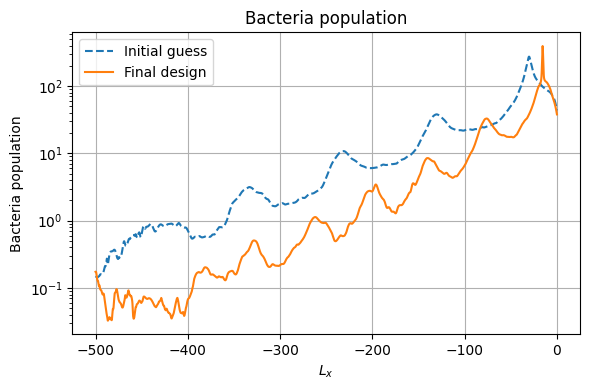

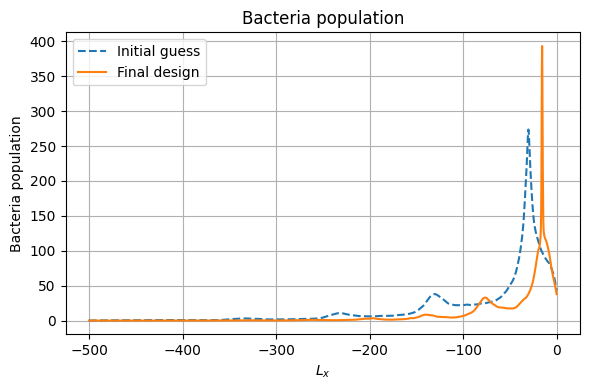

In [9]:
# Draw initial guess and final designs 

L_x, L_p, x2, x3, h = 500, 100.0, -40.0, -30.0, 25.0
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 4))
plt.plot(X0, Y0, "--", label="Initial guess")
L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.plot(X0, Y0, label="Final design")
plt.legend()
plt.title("Design shape")
plt.ylabel("$h$")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("design.png")


xx_mask = np.linspace(1.0, 0, N_s) * (-L_x)
#######################################################################
plt.figure(figsize=(6, 4))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), "--", label="Initial guess")
plt.semilogy(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), label="Final design")
plt.legend()
plt.title("Bacteria population")
plt.grid("on")
plt.ylabel("Bacteria population")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("bacteria_population_semilogy.png")


#######################################################################
plt.figure(figsize=(6, 4))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), "--", label="Initial guess")
plt.plot(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), label="Final design")
plt.legend()
plt.title("Bacteria population")
plt.grid("on")
plt.ylabel("Bacteria population")
plt.xlabel("$L_x$")
plt.tight_layout()
plt.savefig("bacteria_population.png")

fno_loss =  224575.9375 ref_loss =  -0.0


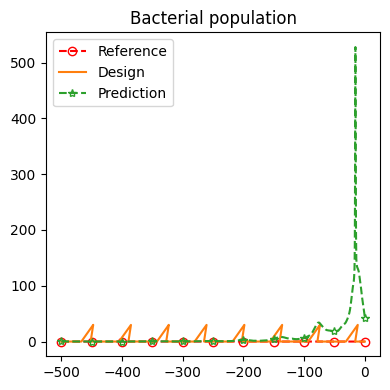

In [10]:
import glob
# Design validation

train_data_folder = "data"
t = 9


N_s, L_x = 2001, 500
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)

samples = [0]
x_mesh, y_mesh = np.zeros((len(samples), N_s)), np.zeros((len(samples), N_s))
density_1d_data_all = np.zeros((len(samples), N_s, 3))
density_1d_data = np.zeros((len(samples), N_s))
L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
# L_p, x1, x2, x3, h = 62.32211685180664, -31.16105842590332, -11.533348083496094, -16.148033142089844, 29.966632843017578

for i in range(len(samples)):
    
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/tri*")
    for file_name in file_names:
        
        print(file_name)
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)

    plt.figure(figsize=(4,4))
    plt.plot(xx,  density_1d_data[i, :], "--o", color="red", markevery=len(xx_mask)//10, fillstyle='none', label="Reference")
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C1", label="Design")
    
    ref_loss = -np.sum(np.matmul(density_1d_data[i, :], xx))* L_x/N_s
    

    x, XC, YC = catheter_mesh_1d_total_length(L_x, torch.tensor(L_p), torch.tensor(x2), torch.tensor(x3), h, N_s)
    out = torch.exp(model(x)).mean(-1).squeeze()
    fno_loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    print("fno_loss = ", fno_loss.item(), "ref_loss = ", ref_loss)
        
    plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "--*", color="C2", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
    plt.legend()
    plt.title("Bacterial population")
    plt.tight_layout()
    plt.savefig("Design_tri.pdf")



# Plot 

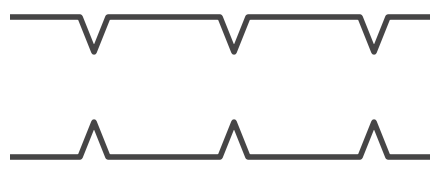

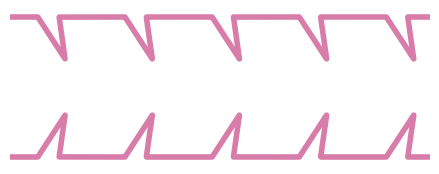

In [25]:
# Draw initial guess and final designs 

L_x, L_p, x2, x3, h = 500, 100.0, -40.0, -30.0, 25.0
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 2))
plt.plot(X0, 100-Y0, color="#464546", linewidth=4.0)
plt.plot(X0, Y0, color="#464546", linewidth=4.0)
plt.axis('off'),
plt.xlim([-300, 0])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig("initial_guess.pdf")

L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, -15.864848136901855, 29.99827766418457
x1 = -0.5*L_p
N_s = 2001
X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
plt.figure(figsize=(6, 2))
plt.plot(X0, 100-Y0, color="#D87CA9", linewidth=4.0)
plt.plot(X0, Y0, color="#D87CA9", linewidth=4.0)
plt.axis('off'),
plt.xlim([-300, 0])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig("final_guess.pdf")
# plt.title("Design shape")
# plt.ylabel("$h$")
# plt.xlabel("$L_x$")
# plt.savefig("design.png")




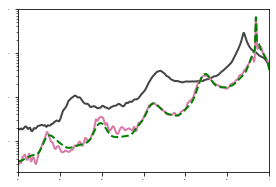

In [37]:
xx_mask = np.linspace(1.0, 0, N_s) * (-L_x)
#######################################################################
plt.figure(figsize=(4.5, 3))
plt.plot(xx_mask, bacteria_pred[0].detach().cpu().numpy(), color="#464546", linewidth=2.0, label="initial design")
plt.semilogy(xx_mask, bacteria_pred[-1].detach().cpu().numpy(), color="#D87CA9", linewidth=2.0, label="optimized design")
plt.semilogy(xx_mask, density_1d_data[i, :], "--",  color="green", linewidth=2.0)

plt.xlim([-300, 0])
plt.ylim([0.2, 1e3])
#plt.grid(linestyle='--', linewidth=0.5)


# plt.legend(loc = "upper center",bbox_to_anchor=(0.5,1.15),ncol=2)
# plt.tight_layout()
plt.tick_params(labelsize=0) 
# plt.yticks(labelsize=0) 
plt.savefig("bacteria_population_semilogy.pdf")




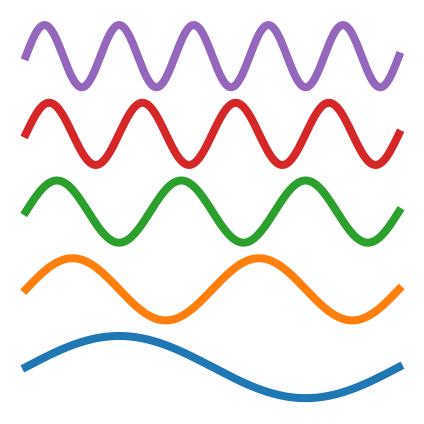

In [54]:
# Draw Fourier basis functions

xx = np.linspace(0, 1, 1001)

plt.figure(figsize=(6, 6))
dy = 2.5
shift = 0
for i in range(5):
    plt.plot(xx, np.sin(2*np.pi*(i+1)*xx)+shift*dy, color="C"+str(i),  linewidth=8.0)
    shift += 1.0
#     plt.plot(xx, np.cos(2*np.pi*(2*i+2)*xx)+shift*dy,   linewidth=4.0)
#     shift += 1.0
plt.axis('off'),
# ax = plt.gca()
# # ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("Fourier_basis_functions.pdf")



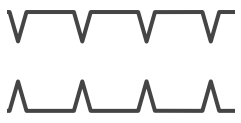

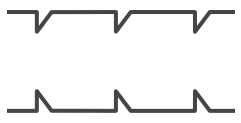

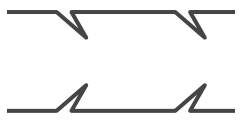

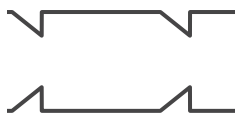

In [5]:
L_x = 500
L_ps = [65, 80, 120, 150]
x2s = [-L_ps[0]/2+ 8.5, -L_ps[1]/2, -L_ps[2]/2 + 30.0, -L_ps[3]/2 + 30.0]
x3s = [-L_ps[0]/2 + 17.0, -L_ps[1]/2 + 15, -L_ps[2]/2 + 15.0, -L_ps[3]/2 + 30.0]

hs = [29.9, 20, 26, 24]
for i in range(4):
    L_p = L_ps[i] 
    x1 = -L_p/2.0
    x2, x3 = x2s[i], x3s[i]
    h = hs[i]

    N_s = 2001
    X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    plt.figure(figsize=(6, 2))
    plt.plot(X0, 100-Y0, color="#464546", linewidth=4.0)
    plt.plot(X0, Y0, color="#464546", linewidth=4.0)
    plt.axis('off'),
    plt.xlim([-230, 0])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.savefig("design_data_"+str(i)+".pdf")

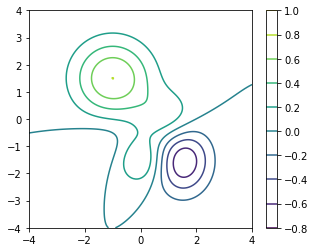

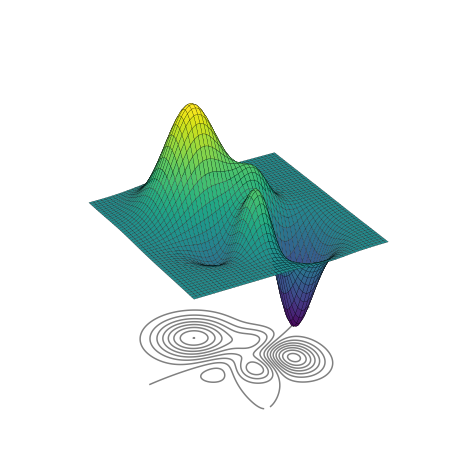

In [131]:
def Gaussian_helper(x, m, C):
    return np.exp(-0.5*np.dot(x - m , np.linalg.solve(C,x - m)))
    
def Gaussian(X, Y, m, C):
    nx, ny = X.shape
    Z = np.zeros((nx, ny))
    for ix in range(nx):
        for iy in range(ny):
            Z[ix, iy] = Gaussian_helper(np.array([X[ix, iy], Y[ix, iy]]), m, C)
    return Z

nx, ny = 200, 200
xx = np.linspace(-4, 4, nx)
yy = np.linspace(-4, 4, ny)
X, Y = np.meshgrid(xx ,yy)


Z = np.zeros((nx, ny))
Z += 0.8*Gaussian(X, Y, np.array([-1.0, 1.5]), np.array([[1.0, 0.0], [0.0, 1.0]]))
Z += 0.4*Gaussian(X, Y, np.array([1.0, 0.0]), np.array([[0.5, 0.0], [0.0, 0.5]]))
Z += 0.5*Gaussian(X, Y, np.array([0.0, -1.5]), np.array([[0.4, 0.0], [0.0, 0.4]]))
Z += -0.2*Gaussian(X, Y, np.array([-1.2, -1.0]), np.array([[0.8, 0.0], [0.0, 0.5]]))
Z += -0.8*Gaussian(X, Y, np.array([1.5, -1.5]), np.array([[0.5, 0.0], [0.0, 0.8]]))

plt.figure(figsize=(5,4))
# plt.pcolormesh(X, Y, Z)
plt.contour(X, Y, Z)
plt.colorbar()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.2, linestyles="solid", edgecolors='k', rstride=4, cstride=4)
# # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.contour(X, Y, Z, 15, colors="grey", linestyles="solid", offset=-1.0)
# ax.set_xlabel("x")
ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
ax.view_init(30, -120)
fig.savefig("optimization.pdf")
# fig = plt.figure(figsize=(4,3))
# ax = fig.add_subplot(111, projection='3d')

# # Z += np.sin(np.pi*X)*np.sin(np.pi*Y)
# ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.1, rstride=1, cstride=1)
# # # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
# ax.contour(X, Y, Z, 10, colors="k", linestyles="solid", offset=-0.5)

# ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
# # ax.view_init(30, 30)
# plt.show()


# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
# fig.axes.get_zaxis().set_visible(False)
# 
# # ax.set_xticks([0, -30, -60])
# ax.tick_params(axis='x', which='major', pad=-4)
# ax.set_xlabel(r"$x_2$", labelpad=-5)
# # ax.set_yticks([0, -8, -16])
# ax.tick_params(axis='y', which='major', pad=-4)

# ax.set_ylabel(r"$x_3$", labelpad=-5)
# # ax.set_zticks([3e5, 6e5, 9e5])
# ax.tick_params(axis='z', which='major', pad=-4)

# # ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
# fig.tight_layout()
# fig.savefig("landscape-1.pdf")

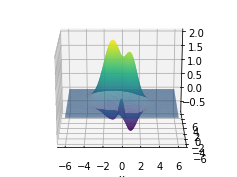

In [87]:

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.0, rstride=1, cstride=1)
# # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
# ax.contour(X, Y, Z, 10, colors="k", linestyles="solid", offset=-0.5)
ax.set_xlabel("x")
# ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
ax.view_init(20, -90)
plt.show()

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'lw'
  # Remove the CWD from sys.path while we load stuff.
/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'lw'
  # This is added back by InteractiveShellApp.init_path()


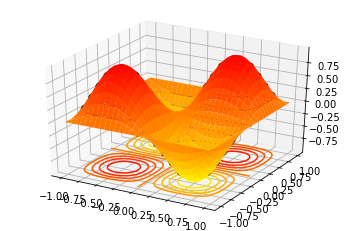

In [90]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
ax.plot_surface(X, Y, Z, cmap="autumn_r", lw=0.5, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
plt.show()

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'lw'
  


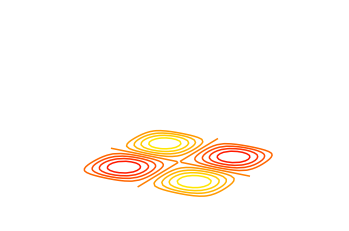

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
# ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.0, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.set_axis_off()
plt.show()